In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.ref_book import ReferenceBookAnonymization

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра

### Этап 1: Сравнение результатов на наборе данных i2b2 2014
Сравнение будет включает в себя измерение метрик Recall, Precision и $F_1$ score для следующий моделей:
* BERT-base-cased
* BERT-base-uncased
* BERT-large-cased
* BERT-large-uncased

#### BERT-base-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

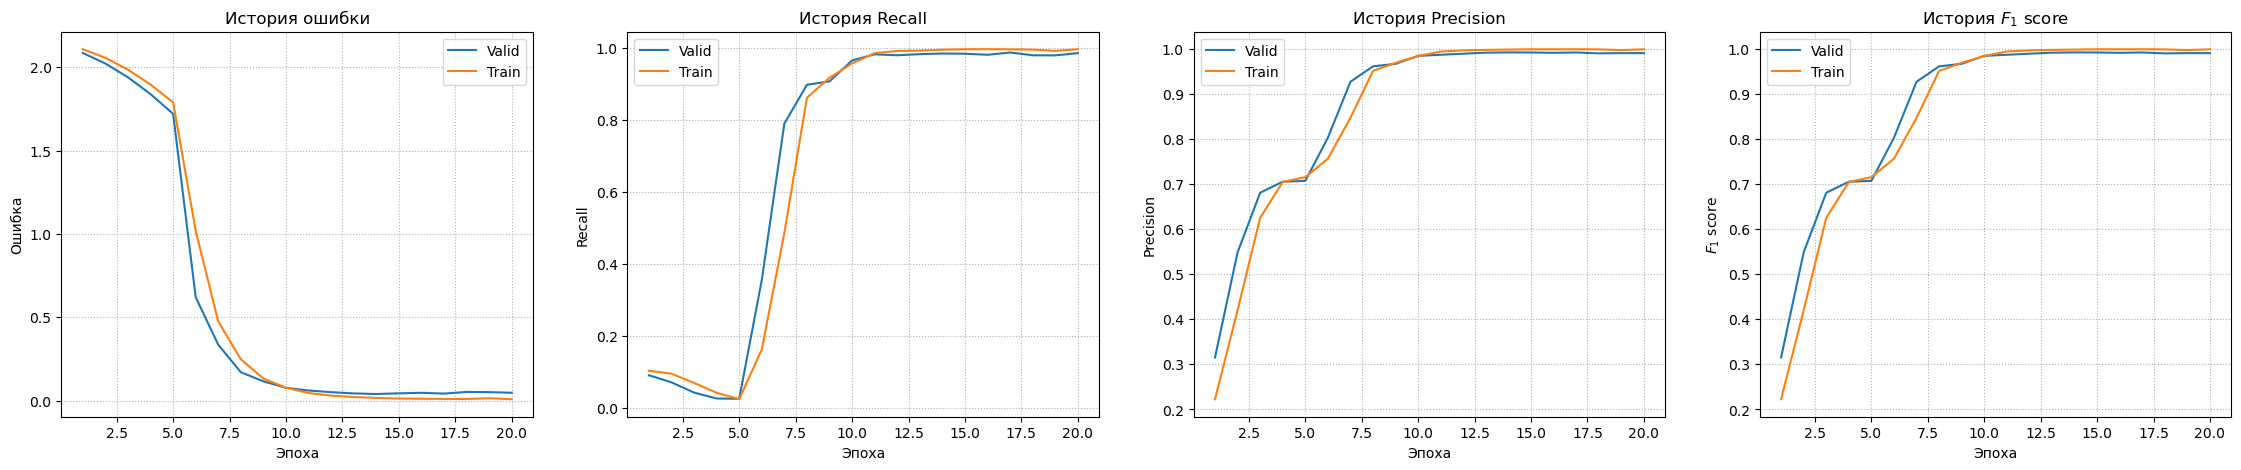

In [7]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(2)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [8]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer=i2b2_2014_data_config["pretrained_tokenizer_path"],
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path()
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [10]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9942045211791992
     test_precision         0.9942045211791992
       test_recall          0.9913195967674255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9913195967674255,
  'test_precision': 0.9942045211791992,
  'test_f1': 0.9942045211791992}]

              precision    recall  f1-score   support

        NAME     0.9733    0.9901    0.9816      3023
  PROFESSION     0.0000    0.0000    0.0000        13
    LOCATION     0.9300    0.9789    0.9538      2227
         AGE     0.9913    0.9942    0.9927       343
        DATE     0.9984    0.9972    0.9978      5715
          ID     0.9923    0.9967    0.9945      1804
     CONTACT     0.9948    0.9914    0.9931       584
           O     0.9688    0.9953    0.9819     37538

   micro avg     0.9718    0.9942    0.9829     51247
   macro avg     0.8561    0.8680    0.8619     51247
weighted avg     0.9717    0.9942    0.9828     51247



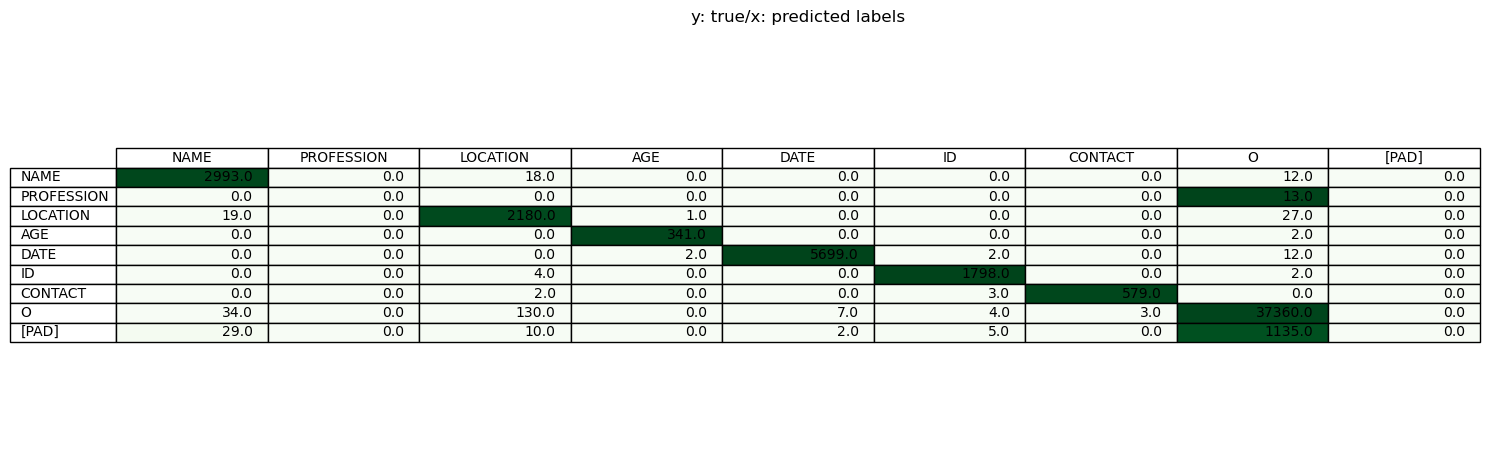

Wrongly predicted examples:
_____ Record 215-05 _____
| Sentence:    | record | date | : | 2130 | -    | 08   | -    | 09   | cardiology | elkhorn  | valley   | clinic   | reason | for | visit | : | a | 59  | yr | old | iddm | man | s | / | p | cabg | in | 25   | with | iddm | and | chf | admitted | after | elective | cardiac | cath | which | revealed | new | rca | occlusion | for | post | hydration | / | mucomyst | / | bicarb | . | interval | history | : | cardiac | history | began | in | 2125 | with | inappropriate | sinus | tachycardia | . | a | cardiac | echo | revealed | ef | of | 64 | % | with | no | valvular | disease |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | O          | LOCATION | LOCATION | LOCATION | O      | O   | O     | O | O | AGE | O  | O   | O    | O   | O | O | O | O    | O  | DATE | O    | O    | O   | O   | O        | O     | O        | O       | O    | O     | O        | O   | O   | O         | O   | O    | O         | O | O        |

In [11]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-base-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

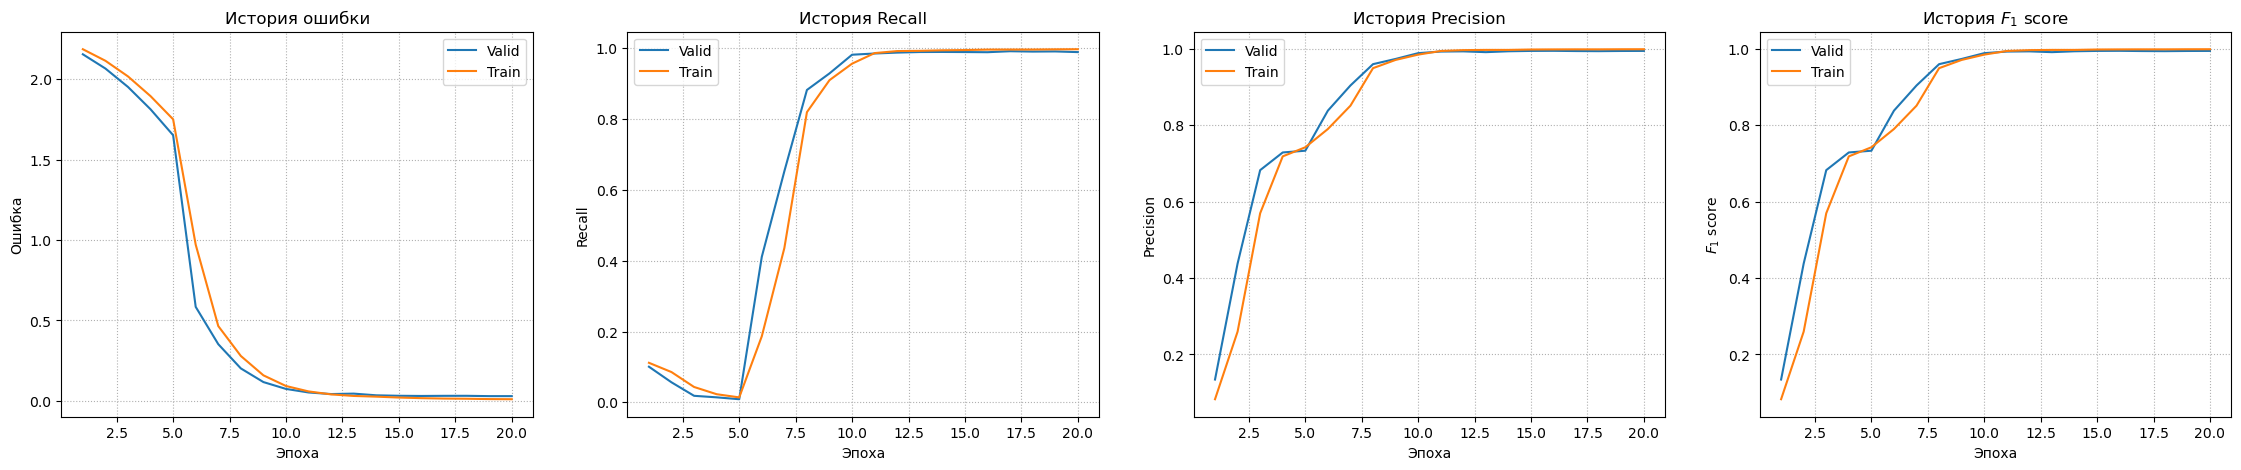

In [12]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(3)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [13]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer=i2b2_2014_data_config["pretrained_tokenizer_path"],
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [14]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path()
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [15]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9942045211791992
     test_precision         0.9942045211791992
       test_recall          0.9913195967674255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9913195967674255,
  'test_precision': 0.9942045211791992,
  'test_f1': 0.9942045211791992}]

              precision    recall  f1-score   support

        NAME     0.9733    0.9901    0.9816      3023
  PROFESSION     0.0000    0.0000    0.0000        13
    LOCATION     0.9300    0.9789    0.9538      2227
         AGE     0.9913    0.9942    0.9927       343
        DATE     0.9984    0.9972    0.9978      5715
          ID     0.9923    0.9967    0.9945      1804
     CONTACT     0.9948    0.9914    0.9931       584
           O     0.9688    0.9953    0.9819     37538

   micro avg     0.9718    0.9942    0.9829     51247
   macro avg     0.8561    0.8680    0.8619     51247
weighted avg     0.9717    0.9942    0.9828     51247



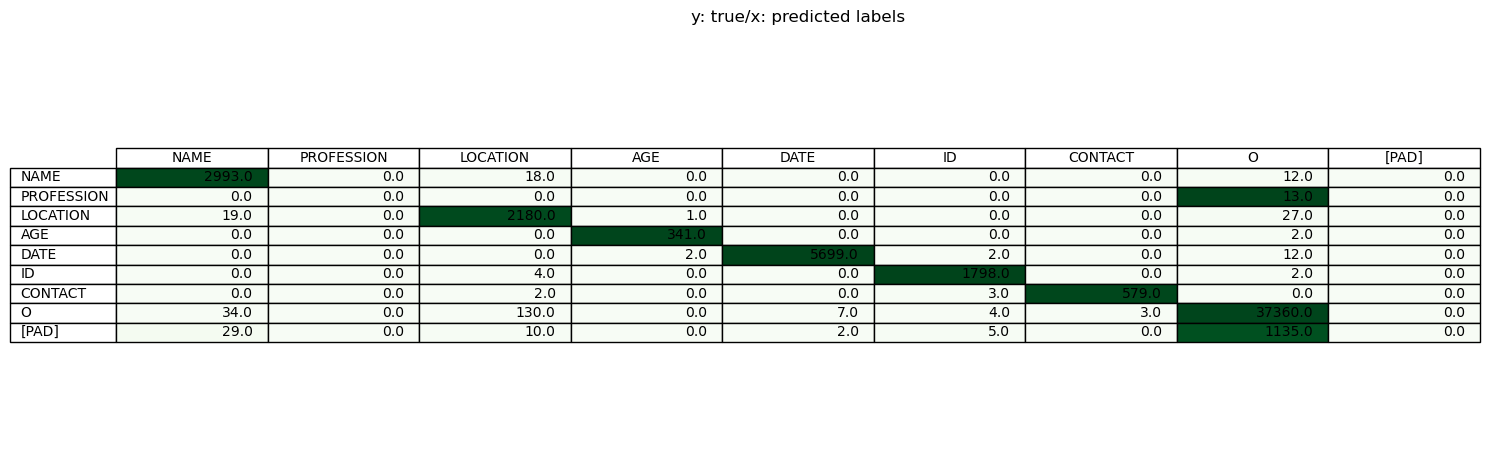

Wrongly predicted examples:
_____ Record 197-04 _____
| Sentence:    | record | date | : | 2098 | -    | 12   | -    | 10   | 059 | -  | 57 | -  | 26 | emery | ,    | donn | december | 10   | ,    | 2098 | endocrine | / | diabetes | present | illness | : | asked | to | see | this | 89  | year | old | patient | of | drs | . | pina | and  | keefe | , | admitted | with | an | acute | exacerbation | of | congestive | heart | failure | in | the | context | of | severe | aortic | stenosis | and | less | attention | to | diet | at | the | time | of | his | wife | ' | s | death | last | week | . | he | is | approaching | probable | avr | and | ? |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | ID  | ID | ID | ID | ID | NAME  | NAME | NAME | DATE     | DATE | DATE | DATE | O         | O | O        | O       | O       | O | O     | O  | O   | O    | AGE | O    | O   | O       | O  | O   | O | NAME | O    | NAME  | O | O        | O    | O  | O     | O            | O  | O 

In [16]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

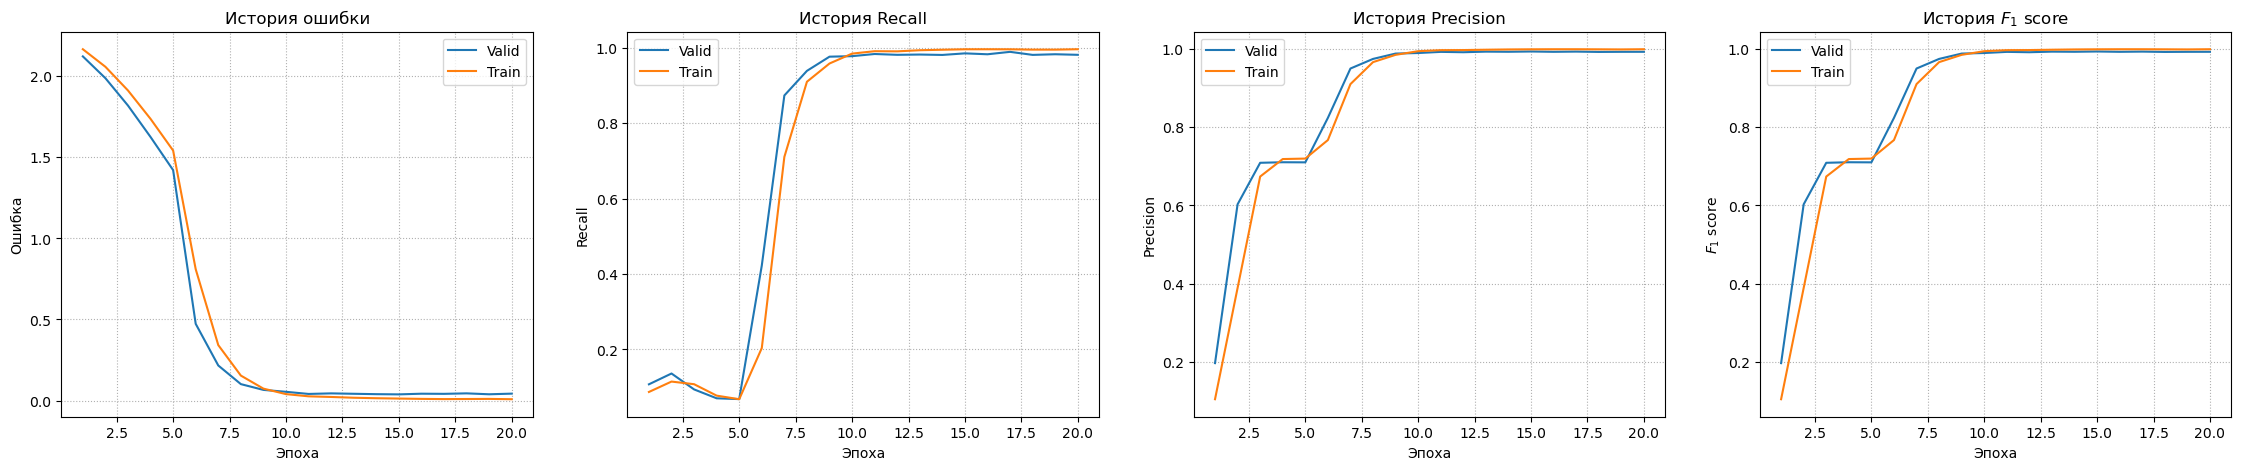

In [17]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(2)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [18]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer=i2b2_2014_data_config["pretrained_tokenizer_path"],
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [19]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path()
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [20]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9950436353683472
     test_precision         0.9950436353683472
       test_recall          0.9922678470611572
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9922678470611572,
  'test_precision': 0.9950436353683472,
  'test_f1': 0.9950436353683472}]

              precision    recall  f1-score   support

        NAME     0.9727    0.9904    0.9815      3023
  PROFESSION     1.0000    0.3077    0.4706        13
    LOCATION     0.9454    0.9793    0.9621      2227
         AGE     0.9552    0.9942    0.9743       343
        DATE     0.9983    0.9984    0.9983      5715
          ID     0.9934    0.9956    0.9945      1804
     CONTACT     0.9748    0.9949    0.9847       584
           O     0.9696    0.9961    0.9827     37538

   micro avg     0.9726    0.9950    0.9837     51247
   macro avg     0.9762    0.9071    0.9186     51247
weighted avg     0.9727    0.9950    0.9837     51247



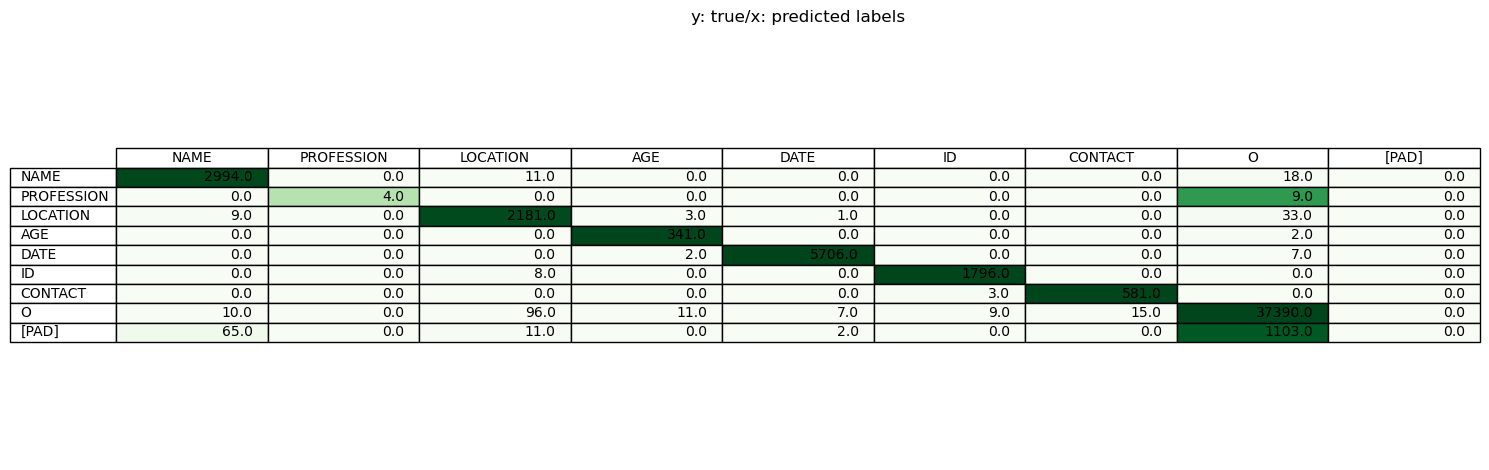

Wrongly predicted examples:
_____ Record 164-05 _____
| Sentence:    | record | date | : | 2085 | -    | 06   | -    | 16   | 83  | yo | male | for | f | / | u | of | heart | disease | and | bp | . | he | states | he | is | fine | and | denies | any | chest | pressure | , | dyspnea | or | abd | pain | . | denies | any | bleeding | from | stools | . | problems | mental | retardation | hypertension | anemia | benign | prostatic | hypertrophy | : | s | / | p | turp | 4    | /    | 84   | h | / | o | peptic | ulcer | disease | : | dx | . | by | upper | endoscopy | in | 2069 | . | coronary | artery | disease | : |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | AGE | O  | O    | O   | O | O | O | O  | O     | O       | O   | O  | O | O  | O      | O  | O  | O    | O   | O      | O   | O     | O        | O | O       | O  | O   | O    | O | O      | O   | O        | O    | O      | O | O        | O      | O           | O            | O      | O      | O         | O    

In [21]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-base-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

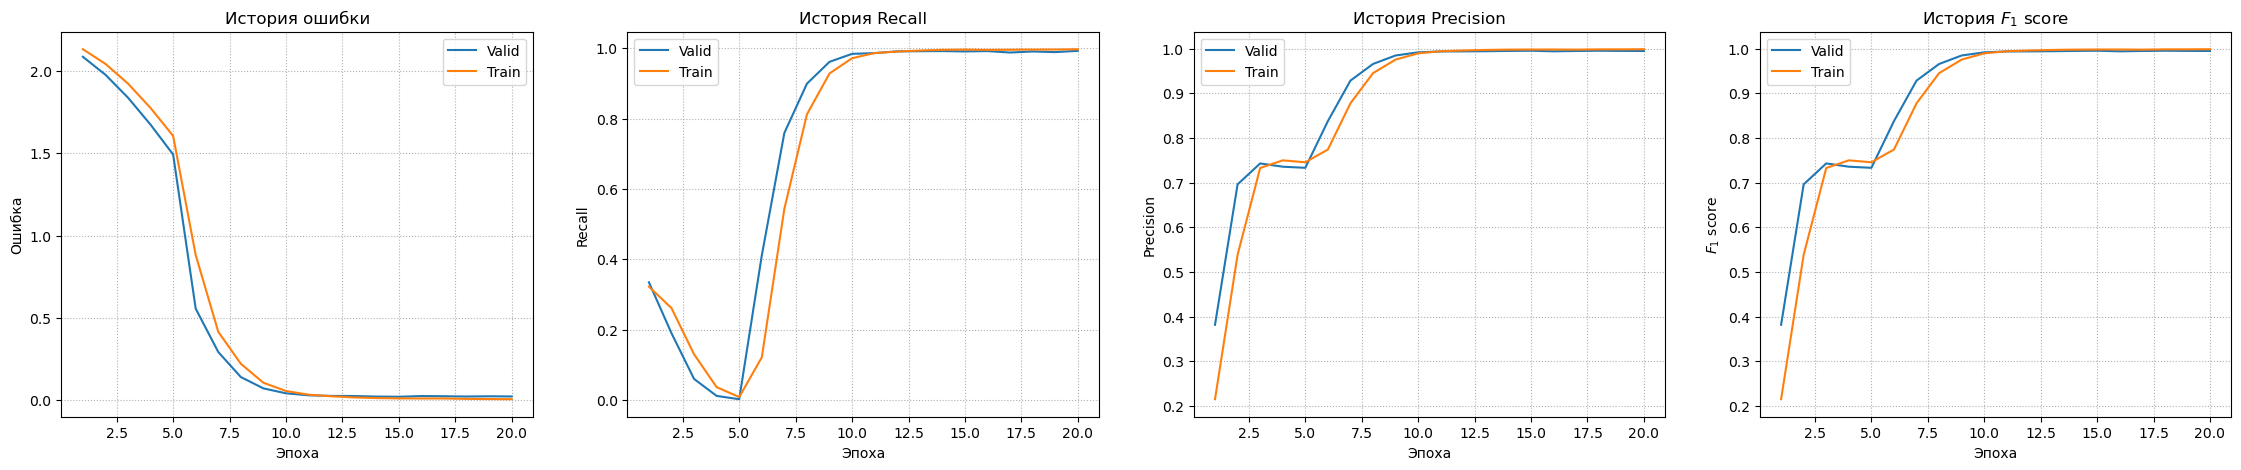

In [22]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(3)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [23]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer=i2b2_2014_data_config["pretrained_tokenizer_path"],
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [24]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path()
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [25]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9950436353683472
     test_precision         0.9950436353683472
       test_recall          0.9922678470611572
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9922678470611572,
  'test_precision': 0.9950436353683472,
  'test_f1': 0.9950436353683472}]

              precision    recall  f1-score   support

        NAME     0.9727    0.9904    0.9815      3023
  PROFESSION     1.0000    0.3077    0.4706        13
    LOCATION     0.9454    0.9793    0.9621      2227
         AGE     0.9552    0.9942    0.9743       343
        DATE     0.9983    0.9984    0.9983      5715
          ID     0.9934    0.9956    0.9945      1804
     CONTACT     0.9748    0.9949    0.9847       584
           O     0.9696    0.9961    0.9827     37538

   micro avg     0.9726    0.9950    0.9837     51247
   macro avg     0.9762    0.9071    0.9186     51247
weighted avg     0.9727    0.9950    0.9837     51247



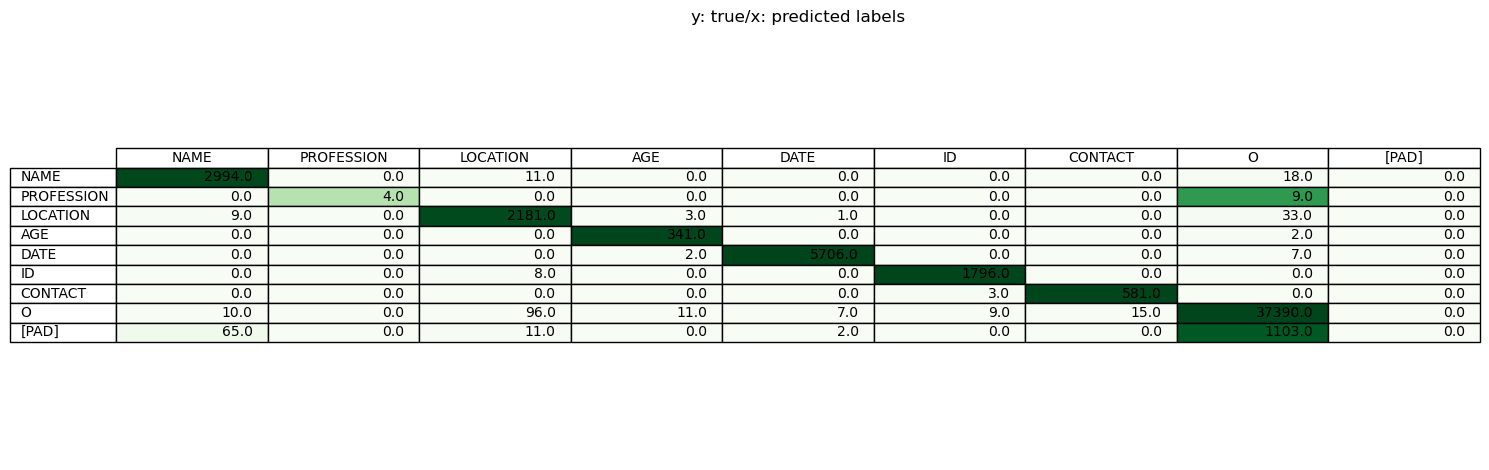

Wrongly predicted examples:
_____ Record 214-03 _____
| Sentence:    | record | date | : | 2096 | -    | 10   | -    | 04   | graydon | harold | jean | , | md | nevada   | hospital | internal | medicine | 72       | dan      | chan     | angels   | city     | , | nh       | 31731    | dear | dr | . | jean | : | your | patient | henry | oswaldo | was | seen | today | by | myself | at | the | atmore   | community | hospital | today | following | coronary | artery | bypass | on | august | 15   | ,    | 2096 | . | he | has | had | a | relatively | unremarkable | recovery | with | out | complication | . | today | , | mr | . | oswaldo | looks | and | feels | well | , | and | complains | of | no | issues | . | on | examination | , | the | lungs |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | NAME    | NAME   | NAME | O | O  | LOCATION | LOCATION | O        | O        | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | O | LOCATION | LOCATION | O    | O  | O | NA

In [26]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

### Этап 2: Демонстрация результатов на наборе данных i2b2 2006
Демонстрация включает в себя измерение метрик Recall, Precision и $F_1$ score для следующий моделей:
* BERT-base-cased
* BERT-base-uncased
* BERT-large-cased
* BERT-large-uncased

#### BERT-base-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

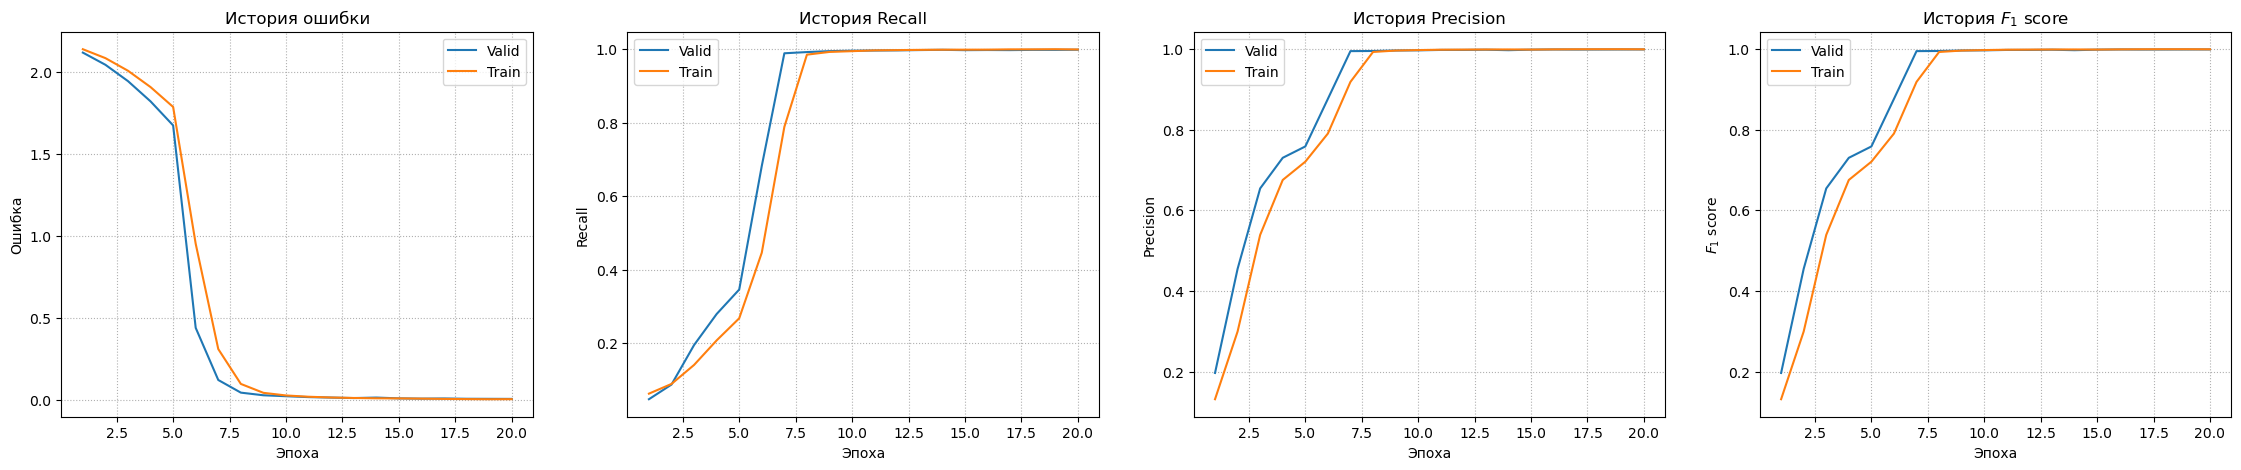

In [27]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(0)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [28]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer=i2b2_2014_data_config["pretrained_tokenizer_path"],
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [29]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path()
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [30]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9942045211791992
     test_precision         0.9942045211791992
       test_recall          0.9913195967674255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9913195967674255,
  'test_precision': 0.9942045211791992,
  'test_f1': 0.9942045211791992}]

              precision    recall  f1-score   support

        NAME     0.9733    0.9901    0.9816      3023
  PROFESSION     0.0000    0.0000    0.0000        13
    LOCATION     0.9300    0.9789    0.9538      2227
         AGE     0.9913    0.9942    0.9927       343
        DATE     0.9984    0.9972    0.9978      5715
          ID     0.9923    0.9967    0.9945      1804
     CONTACT     0.9948    0.9914    0.9931       584
           O     0.9688    0.9953    0.9819     37538

   micro avg     0.9718    0.9942    0.9829     51247
   macro avg     0.8561    0.8680    0.8619     51247
weighted avg     0.9717    0.9942    0.9828     51247



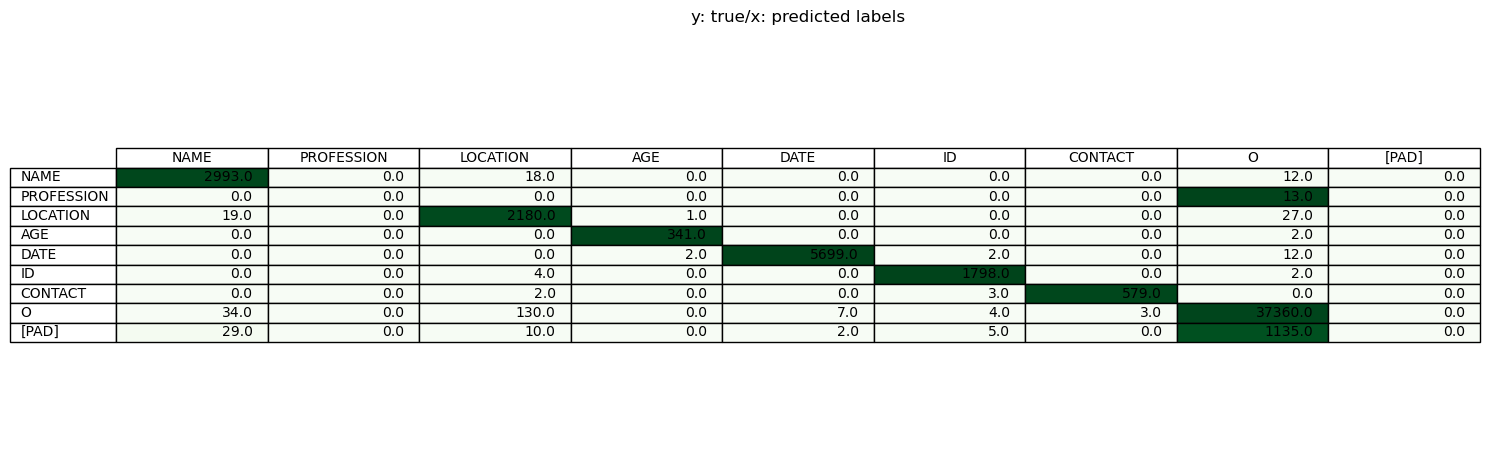

Wrongly predicted examples:
_____ Record 191-01 _____
| Sentence:    | record | date | : | 2091 | -    | 08   | -    | 02   | chief | complaint | aaa      | history | of | present | illness | the | patient | is | a | 66  | y | . | o | . | male | with | aaa | who | is | scheduled | for | endovascular | repair | of | aaa | on | august | 06   | ,    | 2091 | with | dr | . | carter | horne | . | pt | . | was | having | problems | with | tingling | in | right | foot | and | ankle | . | he | went | to | his | pcp | who | as | part | of | the | workup | did | and | ultrasound | and | pt | . | aaa | was | discovered | . | pt | . | had | no | symptoms | then | , | and | has | no | symptoms | now | , |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | O     | O         | O        | O       | O  | O       | O       | O   | O       | O  | O | AGE | O | O | O | O | O    | O    | O   | O   | O  | O         | O   | O            | O      | O  | O   | O  | DATE   | DATE | DATE | D

In [31]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-base-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

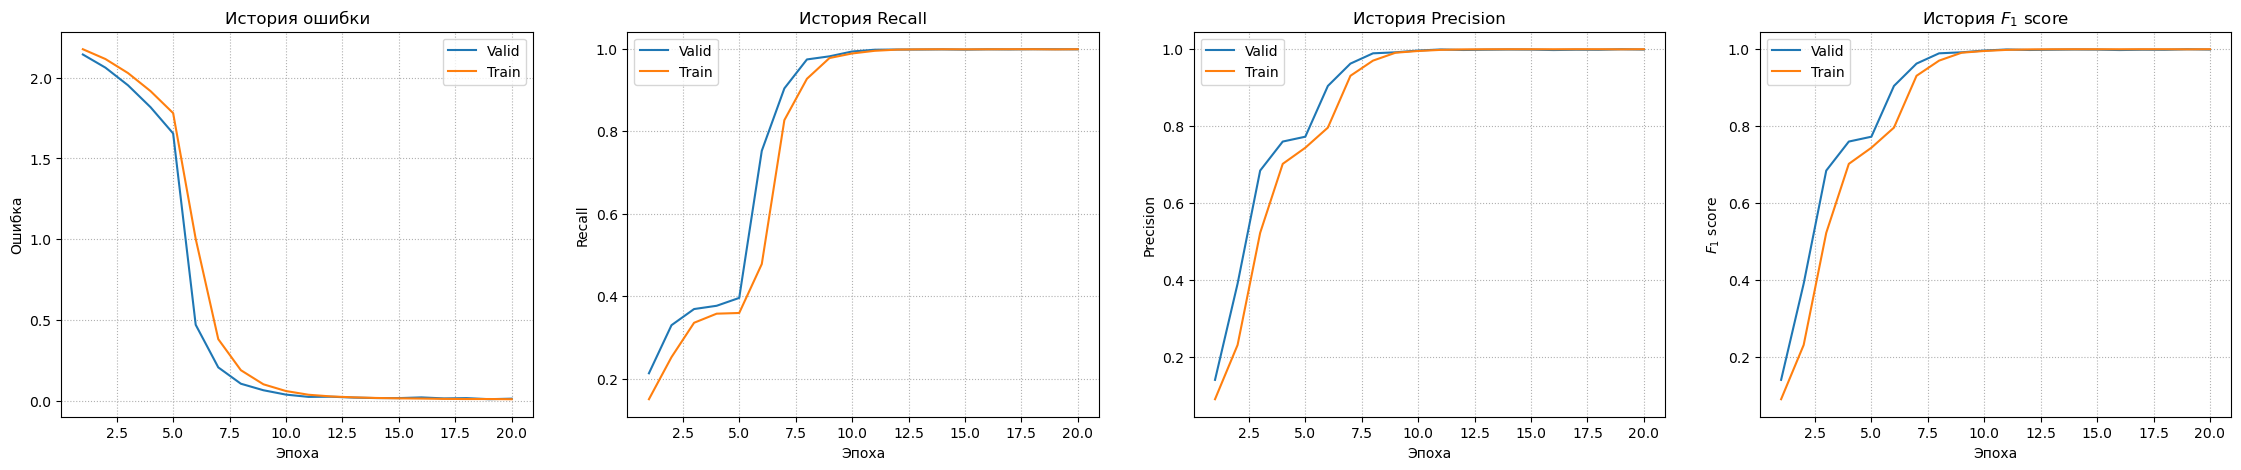

In [32]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(1)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [33]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer=i2b2_2014_data_config["pretrained_tokenizer_path"],
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [34]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path()
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [35]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9942045211791992
     test_precision         0.9942045211791992
       test_recall          0.9913195967674255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9913195967674255,
  'test_precision': 0.9942045211791992,
  'test_f1': 0.9942045211791992}]

              precision    recall  f1-score   support

        NAME     0.9733    0.9901    0.9816      3023
  PROFESSION     0.0000    0.0000    0.0000        13
    LOCATION     0.9300    0.9789    0.9538      2227
         AGE     0.9913    0.9942    0.9927       343
        DATE     0.9984    0.9972    0.9978      5715
          ID     0.9923    0.9967    0.9945      1804
     CONTACT     0.9948    0.9914    0.9931       584
           O     0.9688    0.9953    0.9819     37538

   micro avg     0.9718    0.9942    0.9829     51247
   macro avg     0.8561    0.8680    0.8619     51247
weighted avg     0.9717    0.9942    0.9828     51247



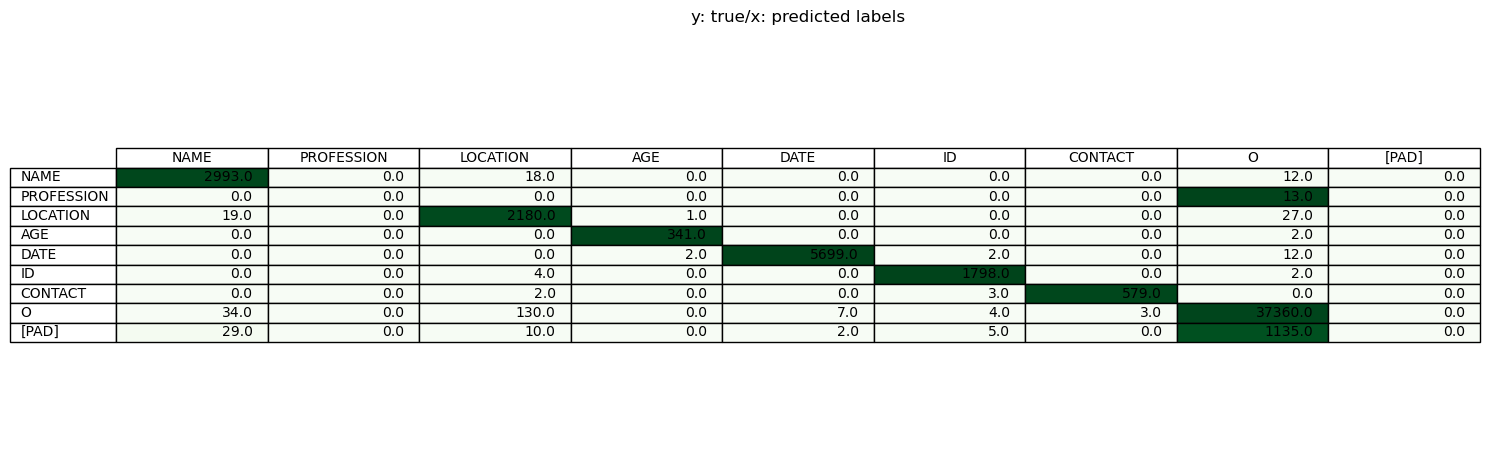

Wrongly predicted examples:
_____ Record 374-03 _____
| Sentence:    | record | date | : | 2133 | -    | 01   | -    | 22   | wise | ,    | willa | internal | medicine | associates | , | suite | 7 | bayne    | -        | jones    | army     | community | hospital | , | 0th | floor | , | noom | 038 | hayti    | ,        | de       | , | 36349    | -        | 2179     | re | : | norma | mckee | 01   | /    | 22   | /    | 2133 | admission | note | ima | consult | note | covering | for | dr | robert | xenakis | cc | 57  | yo | with | multiple | medical | , | psychiatric | problems | admitted | with | recurrent | sbo | and | acute | renal | failure | hpi | pt | has | hx | tab | / | bso | , |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | NAME | NAME | NAME  | O        | O        | O          | O | O     | O | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION  | LOCATION | O | O   | O     | O | O    | O   | LOCATION | O        | LOCATION | O | LOCATION | LOCATION

In [36]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

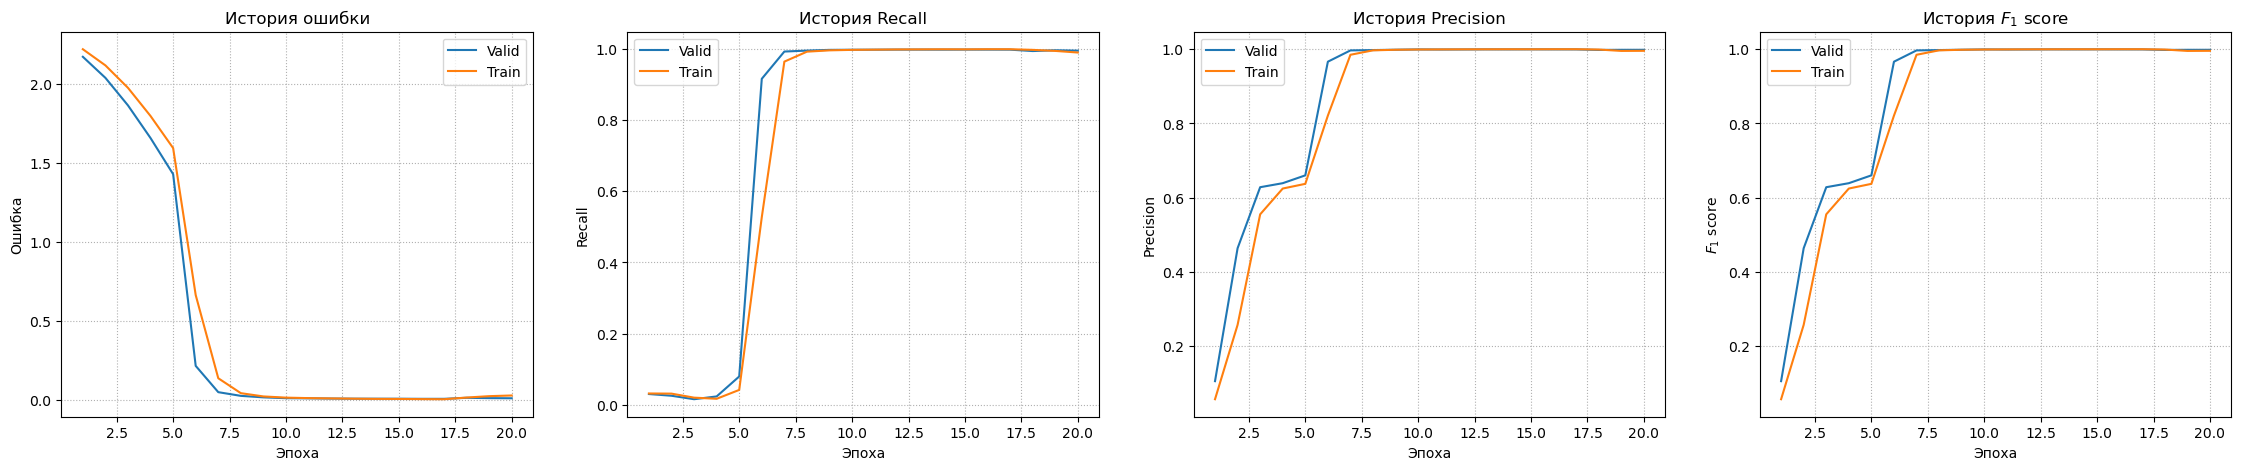

In [37]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(0)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [38]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer=i2b2_2014_data_config["pretrained_tokenizer_path"],
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [39]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path()
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [40]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9950436353683472
     test_precision         0.9950436353683472
       test_recall          0.9922678470611572
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9922678470611572,
  'test_precision': 0.9950436353683472,
  'test_f1': 0.9950436353683472}]

              precision    recall  f1-score   support

        NAME     0.9727    0.9904    0.9815      3023
  PROFESSION     1.0000    0.3077    0.4706        13
    LOCATION     0.9454    0.9793    0.9621      2227
         AGE     0.9552    0.9942    0.9743       343
        DATE     0.9983    0.9984    0.9983      5715
          ID     0.9934    0.9956    0.9945      1804
     CONTACT     0.9748    0.9949    0.9847       584
           O     0.9696    0.9961    0.9827     37538

   micro avg     0.9726    0.9950    0.9837     51247
   macro avg     0.9762    0.9071    0.9186     51247
weighted avg     0.9727    0.9950    0.9837     51247



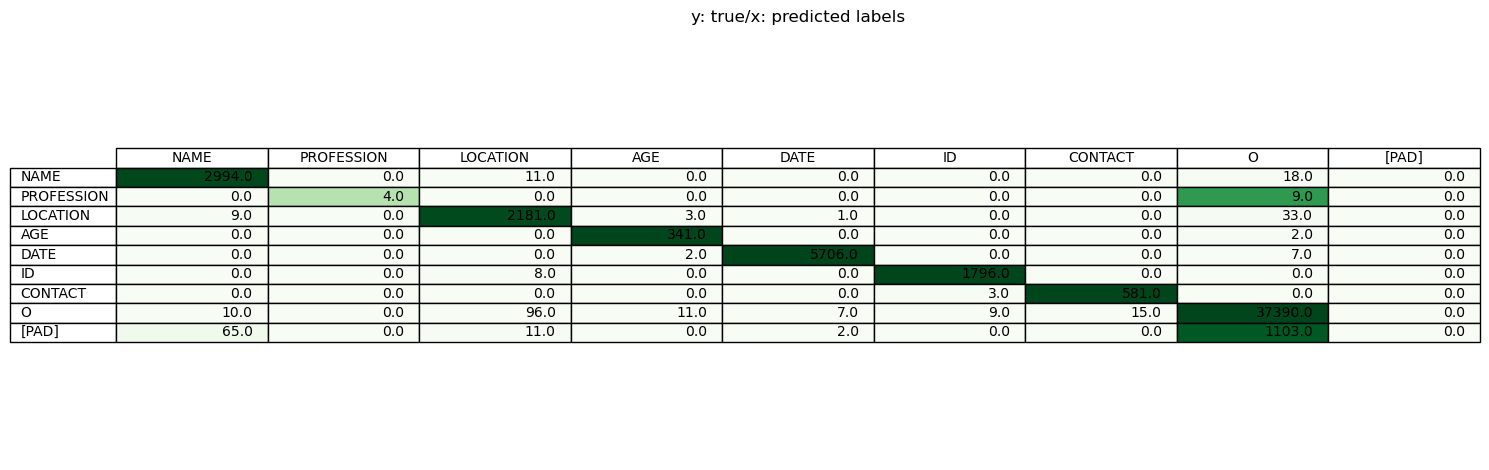

Wrongly predicted examples:
_____ Record 167-02 _____
| Sentence:    | record | date | : | 2078 | -    | 11   | -    | 10   | november | 10   | ,    | 2078 | tanae | shirley | , | m | . | d | . | obstetrics | callaway | district | hospital | 97       | jared    | circle   | falmouth | al       | 98623    | re | : | irene | yarbrough | cdh      | # | 810 | 86 | 43 | 7  | dear | dr | . | shirley | : | thank | you | for | referring | irene | yarbrough | for | evaluation | of | her | atrial | fibrillation | . | mrs | . | yarbrough | is | 55  | years | old | . | over | the | past | year | she | had | had |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | DATE     | DATE | DATE | DATE | NAME  | NAME    | O | O | O | O | O | O          | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | O  | O | NAME  | NAME      | LOCATION | O | ID  | ID | ID | ID | O    | O  | O | NAME    | O | O     | O   | O   | O         | NAME  | NA

In [41]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-base-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

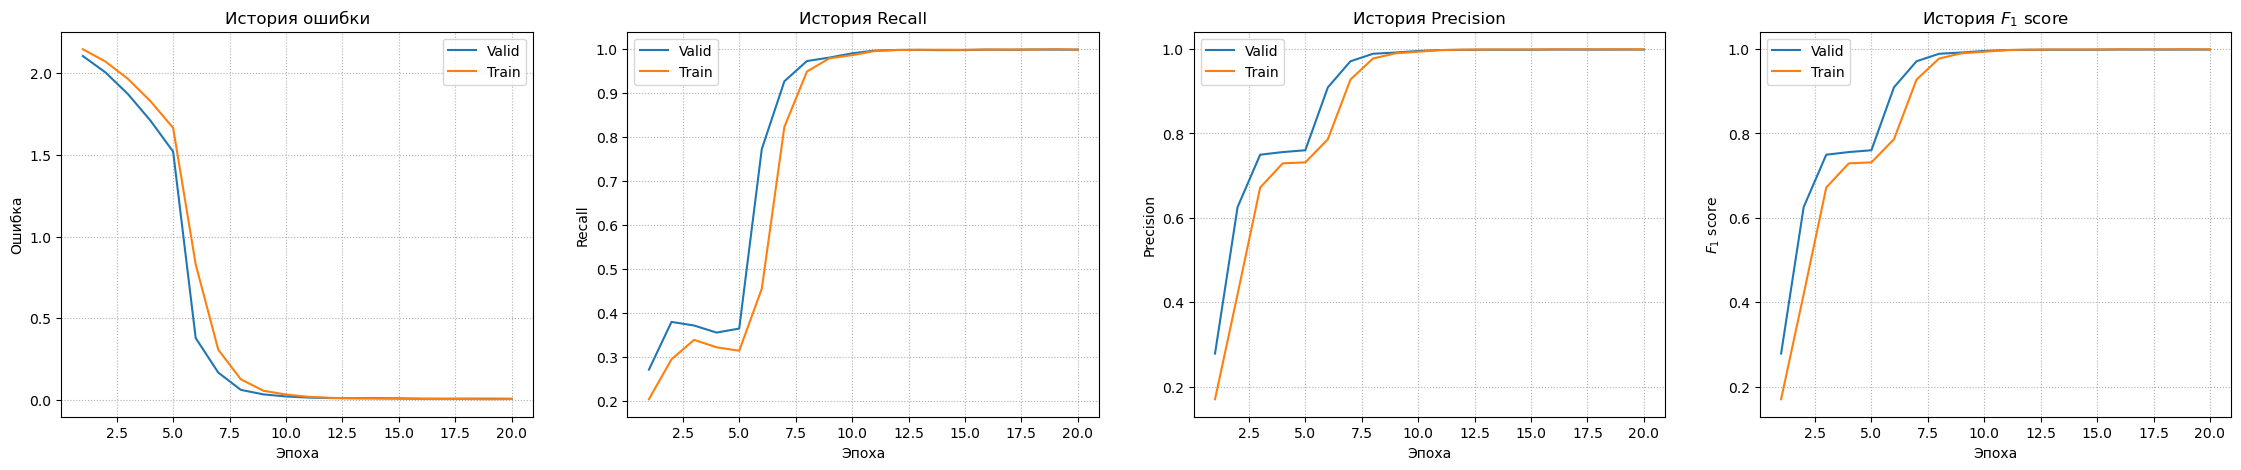

In [42]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(1)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [43]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer=i2b2_2014_data_config["pretrained_tokenizer_path"],
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [44]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path()
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [45]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9950436353683472
     test_precision         0.9950436353683472
       test_recall          0.9922678470611572
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9922678470611572,
  'test_precision': 0.9950436353683472,
  'test_f1': 0.9950436353683472}]

              precision    recall  f1-score   support

        NAME     0.9727    0.9904    0.9815      3023
  PROFESSION     1.0000    0.3077    0.4706        13
    LOCATION     0.9454    0.9793    0.9621      2227
         AGE     0.9552    0.9942    0.9743       343
        DATE     0.9983    0.9984    0.9983      5715
          ID     0.9934    0.9956    0.9945      1804
     CONTACT     0.9748    0.9949    0.9847       584
           O     0.9696    0.9961    0.9827     37538

   micro avg     0.9726    0.9950    0.9837     51247
   macro avg     0.9762    0.9071    0.9186     51247
weighted avg     0.9727    0.9950    0.9837     51247



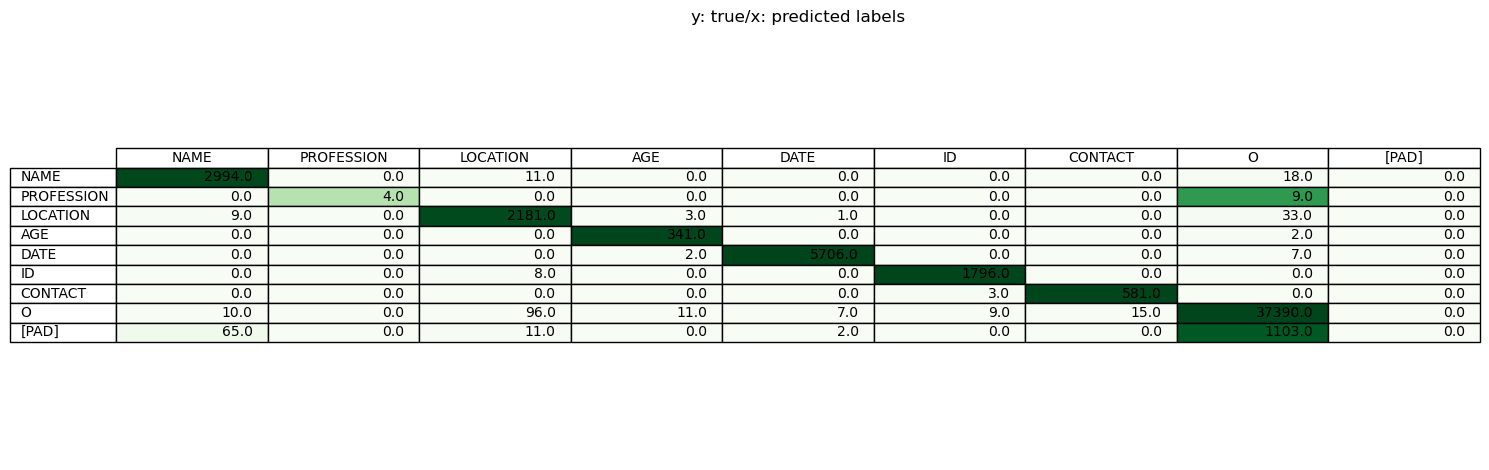

Wrongly predicted examples:
_____ Record 167-04 _____
| Sentence:    | record | date | : | 2090 | -    | 07   | -    | 12   | nightfloat | admit | note | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | name | : | yarbrough | ,    | irene | h    | mrn | : | 81086437 | date | of | admission | : | 7    | /    | 12   | /    | 90   | pcp | : | intern | : | gaines | attending | : | silva | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | O          | O     | O    | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O    | O | NAME      | NAME | NAME  | NAME | O   | O | ID       | O    | O  | O         | O | DATE | DATE | DATE | DATE | DATE | O   | O | O      | O | NAME   | O         | O | NAME  | O | O | O | O | O | O | O | O | 

In [46]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

### Этап 3: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [47]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
anonymization = ReferenceBookAnonymization(anon_config['path_to_first_male_names'],
                                           anon_config['path_to_first_femail_names'],
                                           anon_config['path_to_last_names'],
                                           anon_config['path_to_full_addresses'],
                                           anon_config['path_to_countries'],
                                           anon_config['path_to_states'],
                                           anon_config['path_to_cities'],
                                           anon_config['path_to_streets'],
                                           anon_config['path_to_organizations'],
                                           anon_config['path_to_hospitals'],
                                           anon_config['path_to_professions'])

In [48]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"], 
                               anonymization=anonymization,
                               is_uncased=True,
                               pretrained_tokenizer=i2b2_2014_data_config["pretrained_tokenizer_path"],
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


In [49]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path())

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9874230027198792
     test_precision         0.9874230027198792
       test_recall           0.966221809387207
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.966221809387207,
  'test_precision': 0.9874230027198792,
  'test_f1': 0.9874230027198792}]

              precision    recall  f1-score   support

        NAME     0.9610    0.9597    0.9603      2157
  PROFESSION     1.0000    0.2308    0.3750        13
    LOCATION     0.9197    0.9522    0.9356      3054
         AGE     0.9666    0.9191    0.9422       346
        DATE     0.9975    0.9887    0.9931      5233
          ID     0.9696    0.9369    0.9530      1871
     CONTACT     0.8402    1.0000    0.9132       589
           O     0.9678    0.9948    0.9811     38021

   micro avg     0.9659    0.9874    0.9765     51284
   macro avg     0.9528    0.8728    0.8817     51284
weighted avg     0.9662    0.9874    0.9765     51284



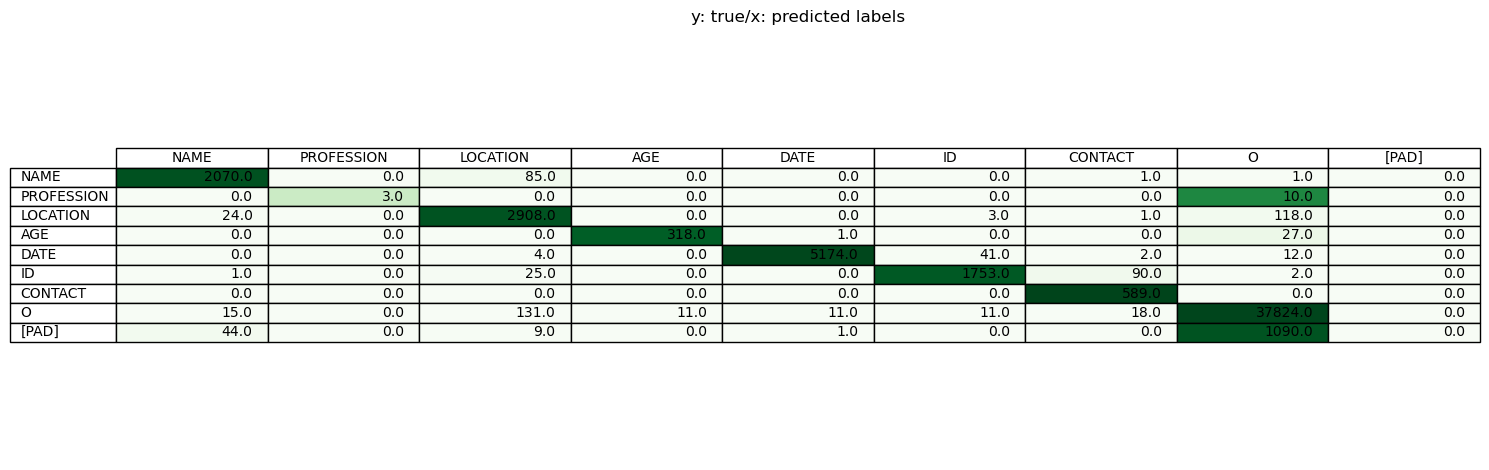

Wrongly predicted examples:
_____ Record 219-03 _____
| Sentence:    | record | date | : | 16   | -    | 09   | -    | 1969 | st       | .        | joseph   | hospital | of       | eureka   | cornhill | thomas   | melissa  | jamshedpur | , | louisiana | 96971    | 636062883144 | (       | 578     | )       | 114     | -       | 1372    | 17   | /    | 04   | /    | 2053 | history | of | present | illness | : | mr | . | ivan | leslie | is | a | 51  | year | old | male | who | comes | for | follow | up | of | hypertension | , | hyperlipidemia | and | other | medical | problems | . | 1 | . | hypertension | . | continues | on | medications | without | chest | pain | , | shortness | of | breath | , | or | pedal |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | NAME     | NAME     | LOCATION   | O | LOCATION  | LOCATION | ID           | CONTACT | CONTACT | CONTACT | CONTACT | CONTACT | CONTAC

In [51]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

В целом все метки предсказываются с той же точностью, что и первоначальные, за исключением метки 'CONTACT'. 
Основная трудность для модели заключается в предсказании номеров телефона. Возможно, ошибкой был выбор российского стандарта их написания.  
Продемонстрируем примеры только с данной ошибкой:

In [52]:
faults = stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:


Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы по-другому.  
Запись **347-03**  
Original:  (121) 537-3484  
Synthetic: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Synthetic: +1 995 672-52-24 
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 4: Дополнительное исследование данных